<a href="https://colab.research.google.com/github/said-mk/ML-Projects/blob/main/Image_Classification_using_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning for Computer Vision Tutorial

## Module Used

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True

## Data Preporcessing Pipline and Device Setup

Download the data from [here](https://download.pytorch.org/tutorial/hymenoptera_data.zip) and extract it to the current directory

Data size ~ 45MB





In [2]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    # ImageNet normalization constants
    transforms.Normalize([0.485, 0.456, 0.406 ],[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    # ImageNet normalization constants
    transforms.Normalize([0.485, 0.456, 0.406 ],[0.229, 0.224, 0.225])
])

data_dir = "/content/drive/MyDrive/data/hymenoptera_data"

train_data = datasets.ImageFolder(os.path.join(data_dir,"train"),train_transforms)

val_data = datasets.ImageFolder(os.path.join(data_dir,"val"), val_transforms)

train_loader = torch.utils.data.DataLoader(
    dataset=train_data,
    batch_size=32,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)
val_loader = torch.utils.data.DataLoader(
    dataset=val_data,
    batch_size=32,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

train_data_size = len(train_data)
val_data_size = len(val_data)
class_names = train_data.classes

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"

print(f"using {device} device")

using cuda device


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## Visualize a few images

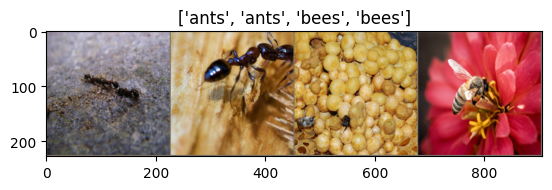

In [3]:
def imshow(data, title=None):

    # PyTorch tensor format to the standard image format for visualization
    data = data.numpy().transpose((1, 2, 0))

    # ImageNet normalization constants
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    data = std * data + mean # denormalizing the images
    data = np.clip(data, 0, 1) # cliping image value between 0 and 1
    plt.imshow(data)
    if title is not None:
        plt.title(title)

# Get a batch of training data
imgs, classes = next(iter(train_loader))
imgs, classes = imgs[:4], classes[:4]
# Make a grid from batch
out = torchvision.utils.make_grid(imgs)

imshow(out, title=[class_names[x] for x in classes])

## Training the Model

### Model Trainig Loop

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # saves training/validation log for visualization
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
        }

    # creates temporary directory as assigned it to "tempdir"
    # saves all intermediate checkpoints fil temporarily
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, "best_model_params.pt")
        # Initial checkpoint:
        # This saves the initial (untrained) state of the model.
        torch.save(model.state_dict(), best_model_params_path)

        best_accuracy = 0.0 # checkpoint parameter

        for epoch in range(num_epochs): # training looop
            print(f"Epoch {epoch}/{num_epochs-1}")
            print("-" * 12)

            # TRAINING PHASE
            model.train()
            running_loss = 0.0
            running_corrects = 0

            for data, labels in train_loader:
                data, labels = data.to(device), labels.to(device)

                # reset the gradients accumulated for each batch
                optimizer.zero_grad()

                outputs = model(data)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Backpropagation
                loss.backward()
                optimizer.step()

                # avg. loss = total loss / Batchsize
                # multiplying the average loss by the batch size reverses the averaging
                running_loss += loss.item() * data.size(0)
                running_corrects += torch.sum(preds == labels)

            scheduler.step() # Apply Learning rate decay

            # dividing running_loss by  train_data_size to represent
            # the model's performance on the entire training dataset(not batch)
            train_epoch_loss = running_loss / train_data_size

            # dividing running_corrects by train_data_size
            # normalized value between 0 and 1.
            # easily interpreted as a percentage.
            train_epoch_acc = running_corrects.double() / train_data_size

            print(f"Train Loss: {train_epoch_loss:.4f} Acc: {train_epoch_acc:.4f}")

            # VALIDATION PHASE
            model.eval()
            running_loss = 0.0
            running_corrects = 0

            # Disabling Gradient Computation
            with torch.no_grad():
                for data, labels in val_loader:
                    data, labels = data.to(device), labels.to(device)

                    outputs = model(data)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    running_loss += loss.item() * data.size(0)
                    running_corrects += torch.sum(preds == labels)

            val_epoch_loss = running_loss / val_data_size
            val_epoch_acc = running_corrects.double() / val_data_size

            print(f"Val Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.4f}")

            history['train_loss'].append(train_epoch_loss)
            history['train_acc'].append(train_epoch_acc.item())
            # .item() converts Tensor to native Python float.
            history['val_loss'].append(val_epoch_loss)
            history['val_acc'].append(val_epoch_acc.item())


            # checkpoint
            if val_epoch_acc > best_accuracy:
                best_accuracy = val_epoch_acc
                # checkpoint: updates model state
                torch.save(model.state_dict(), best_model_params_path)

            print()
        # time taken to train and validate model
        time_elapsed = time.time() - since
        print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
        print(f"Best val Acc: {best_accuracy:.4f}")

        # load best weights
        model.load_state_dict(torch.load(best_model_params_path))

    return model, history


## Visualizing the model predictions

In [5]:
def visualize_model(model, dataloader, device, num_images=4):
  #save the model's current state before going into evaluation mode.
  was_training = model.training
  model.eval()

  # used this to get randomized image from the batch
  dataset = dataloader.dataset
  dataloader = torch.utils.data.DataLoader(
      dataset=dataset,
      batch_size=num_images,
      shuffle=True
  )

  try:
    images, labels = next((iter(dataloader)))
  except StopIteration:
    print("Error:Dataloader is empty or finished")
    model.train(was_training)
    return

  plot_count =  min(num_images, images.size(0))
  if plot_count > 10:
    print("Maximum number of images exceeded!")
    print("num_images reduced to 10")
    plot_count = 10

  images = images.to(device)

  with torch.no_grad():
    outputs = model(images)
    _,predictions = torch.max(outputs,1)

  # copy tensor and move to cpu(main moemory)
  # covert to numpy for visualization
  images_cpu = images.cpu().numpy()
  labels_cpu = labels.cpu().numpy()
  predictions_cpu = predictions.cpu().numpy()

  fig, axes = plt.subplots(1,plot_count,figsize=(15,4))
  print(f"\nDisplaying {plot_count} predictions:")

  if plot_count == 1:# Error Handling:
    axes =[axes]     # TypeError: 'Axes' object is not subscriptable

  for i in range(plot_count):
    ax = axes[i]
    true_id = labels_cpu[i]
    preds_id = predictions_cpu[i]
    color = 'green' if true_id == preds_id else "red"

    # PyTorch tensor(image) format to the standard image format for visualization
    image = images_cpu[i].transpose((1, 2, 0))


    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    image = (image * std) + mean
    image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.set_title(f"predicted: {class_names[preds_id]}", color=color,fontsize=10)

    # add label(True) below the images
    ax.text(0.5, -0.1, f"True: {class_names[true_id]}",
                 transform=axes[i].transAxes,
                 ha='center', va='top', fontsize=10)


    ax.axis('off')

  plt.tight_layout()
  plt.show()
  model.train(mode=was_training)

### Plotting the Training History

In [6]:
def plot_history(history):
  epochs = range(1, len(history["train_loss"]) + 1)
  plt.figure(figsize=(12,4))

  # plot loss
  plt.subplot(1,2,1)
  plt.plot(epochs, history["train_loss"], label="Training Loss")
  plt.plot(epochs, history["val_loss"], label="Validation Loss")
  plt.title("Traninig and Validation Loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt. legend()

  #plot accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs, history["train_acc"], label="Training Accuracy")
  plt.plot(epochs, history["val_acc"], label="Validation Accracy")
  plt.title("Training and Validation Accuracy")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend()


  plt.tight_layout()
  plt.show()


### Finetuning the  Model

In [7]:
# ImageNet pretrained model
finetune_model = models.resnet18(weights='IMAGENET1K_V1')

# Get the input of the FC necessary for tranfer learning
num_feats = finetune_model.fc.in_features

# replacing the ImageNet FC with new FC the classification
finetune_model.fc = nn.Linear(num_feats, 2)

# Move the model to Device
finetune_model = finetune_model.to(device)

# Loss Function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer_ft = optim.SGD(finetune_model.parameters(), lr=0.001, momentum=0.9)

# step learning rate ()
lr_scheduler_ft = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 135MB/s]


### Train and Evaluate the Finetuned Model


In [8]:
finetune_model, finetune_history = train_model(finetune_model, criterion, optimizer_ft, lr_scheduler_ft, num_epochs=10)

Epoch 0/9
------------
Train Loss: 0.6984 Acc: 0.5656
Val Loss: 0.5156 Acc: 0.8105

Epoch 1/9
------------
Train Loss: 0.4714 Acc: 0.8033
Val Loss: 0.2998 Acc: 0.9346

Epoch 2/9
------------
Train Loss: 0.2783 Acc: 0.9262
Val Loss: 0.2269 Acc: 0.9281

Epoch 3/9
------------
Train Loss: 0.2334 Acc: 0.9139
Val Loss: 0.1954 Acc: 0.9608

Epoch 4/9
------------
Train Loss: 0.2211 Acc: 0.9221
Val Loss: 0.1777 Acc: 0.9608

Epoch 5/9
------------
Train Loss: 0.1716 Acc: 0.9426
Val Loss: 0.1710 Acc: 0.9608

Epoch 6/9
------------
Train Loss: 0.1506 Acc: 0.9467
Val Loss: 0.1660 Acc: 0.9542

Epoch 7/9
------------
Train Loss: 0.1323 Acc: 0.9590
Val Loss: 0.1713 Acc: 0.9542

Epoch 8/9
------------
Train Loss: 0.1597 Acc: 0.9303
Val Loss: 0.1684 Acc: 0.9477

Epoch 9/9
------------
Train Loss: 0.1431 Acc: 0.9508
Val Loss: 0.1731 Acc: 0.9477

Training complete in 0m 57s
Best val Acc: 0.9608


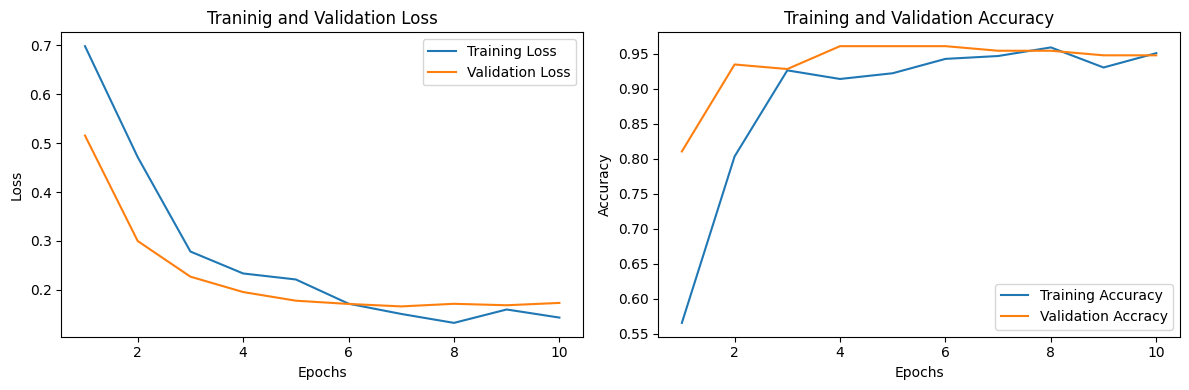

In [9]:
plot_history(finetune_history)


Displaying 6 predictions:


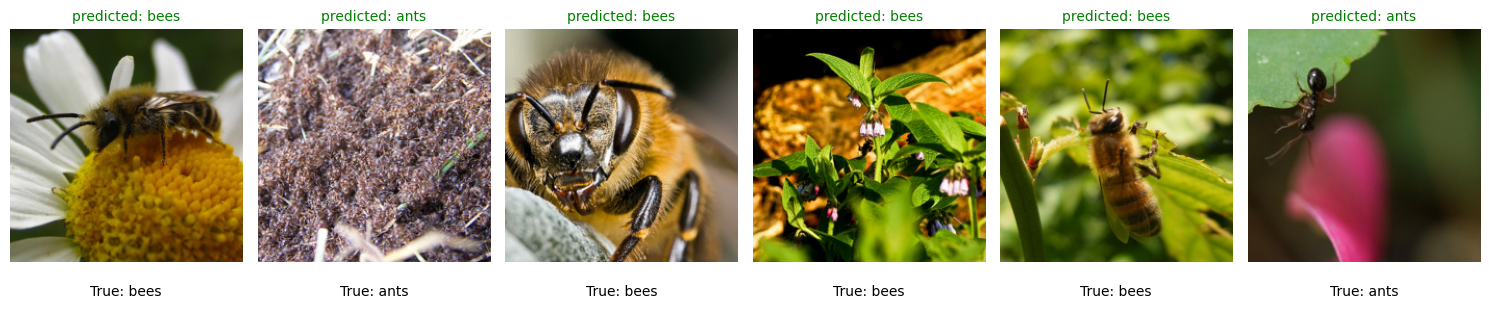

In [10]:
visualize_model(finetune_model,val_loader,device,num_images=6)

### Train and Evaluate Model using Fixed Feature Extraction

In [11]:
ffe_model = models.resnet18(weights='IMAGENET1K_V1')
for param in ffe_model.parameters():
    param.requires_grad = False

num_feats = ffe_model.fc.in_features
ffe_model.fc = nn.Linear(num_feats, 2)

ffe_model = ffe_model.to(device)

criterion = nn.CrossEntropyLoss()


optimizer_ffe = optim.SGD(ffe_model.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
lr_scheduler_ffe = lr_scheduler.StepLR(optimizer_ffe, step_size=7, gamma=0.1)

### Train and evaluate the Fixed Feature Extracted Model

In [12]:
ffe_model, ffe_history = train_model(ffe_model, criterion, optimizer_ffe, lr_scheduler_ffe, num_epochs=25)

Epoch 0/24
------------
Train Loss: 0.6504 Acc: 0.6270
Val Loss: 0.5265 Acc: 0.7059

Epoch 1/24
------------
Train Loss: 0.4897 Acc: 0.7951
Val Loss: 0.3943 Acc: 0.8824

Epoch 2/24
------------
Train Loss: 0.3949 Acc: 0.8607
Val Loss: 0.2932 Acc: 0.9281

Epoch 3/24
------------
Train Loss: 0.3118 Acc: 0.8934
Val Loss: 0.2504 Acc: 0.9346

Epoch 4/24
------------
Train Loss: 0.2650 Acc: 0.9262
Val Loss: 0.2285 Acc: 0.9412

Epoch 5/24
------------
Train Loss: 0.2606 Acc: 0.9344
Val Loss: 0.2107 Acc: 0.9477

Epoch 6/24
------------
Train Loss: 0.2393 Acc: 0.9303
Val Loss: 0.2044 Acc: 0.9412

Epoch 7/24
------------
Train Loss: 0.2105 Acc: 0.9303
Val Loss: 0.2039 Acc: 0.9412

Epoch 8/24
------------
Train Loss: 0.2059 Acc: 0.9467
Val Loss: 0.1986 Acc: 0.9477

Epoch 9/24
------------
Train Loss: 0.1983 Acc: 0.9385
Val Loss: 0.1976 Acc: 0.9542

Epoch 10/24
------------
Train Loss: 0.2165 Acc: 0.9385
Val Loss: 0.1975 Acc: 0.9608

Epoch 11/24
------------
Train Loss: 0.2151 Acc: 0.9303
Val Loss

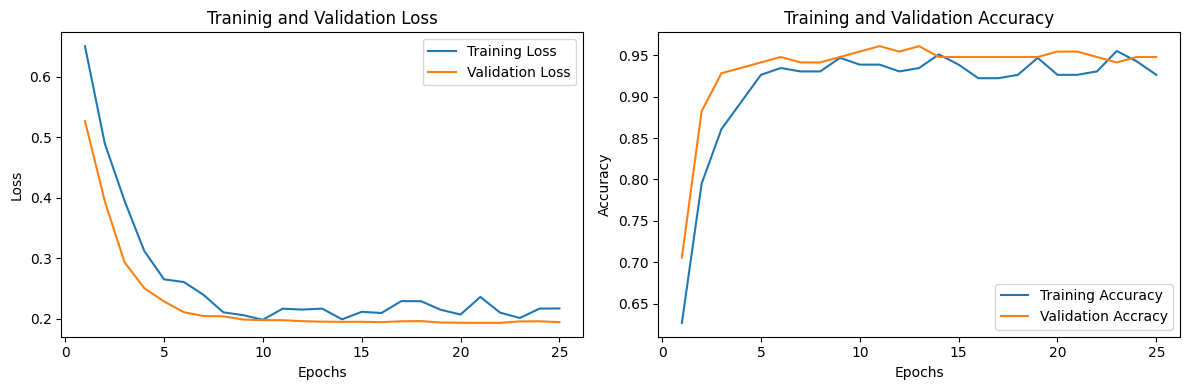

In [13]:
plot_history(ffe_history)


Displaying 6 predictions:


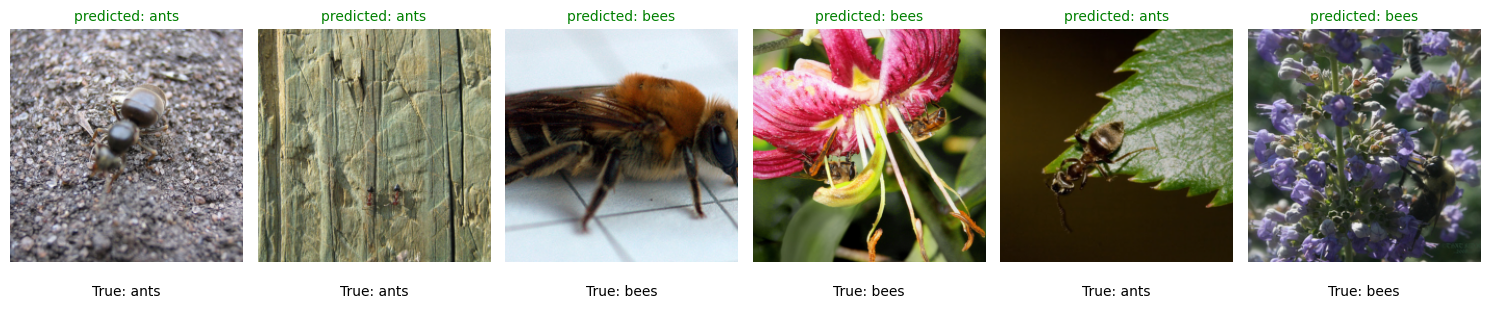

In [14]:
visualize_model(ffe_model,val_loader, device, num_images=6)

## Inference on Custom Images

In [15]:
def visualize_predictions(model, img_paths):
    was_training = model.training
    model.eval()

    if not img_paths:
        print("Error. Empty image path list")
        model.train(mode=was_training)
        return

    img_paths = img_paths[:10]
    num_images = len(img_paths)

    fig, axes = plt.subplots(1, num_images, figsize=(15, 4))
    if num_images == 1:
        axes = [axes]

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    print(f"\nDisplaying predictions for {num_images} image(s)")

    for i, path in enumerate(img_paths):
        ax = axes[i]

        if not os.path.exists(path):
            print(f"Missing file. Skipping {path}")
            ax.set_title("Missing", color='red')
            ax.axis('off')
            continue

        try:
            img_pil = Image.open(path).convert("RGB")
            img_tensor = val_transforms(img_pil)
            img_input = img_tensor.unsqueeze(0).to(device)
        except Exception as e:
            print(f"Bad image. Skipping {path}. Error: {e}")
            ax.set_title("Error", color='red')
            ax.axis('off')
            continue

        with torch.no_grad():
            outputs = model(img_input)
            _, pred = torch.max(outputs, 1)
            predicted_class = class_names[pred.item()]

        img_plot = img_tensor.cpu().numpy().transpose(1, 2, 0)
        img_plot = img_plot * std + mean
        img_plot = np.clip(img_plot, 0, 1)

        ax.imshow(img_plot)
        ax.axis('off')
        ax.set_title(f"Predicted: {predicted_class}", fontsize=11)

    plt.tight_layout()
    plt.show()

    model.train(mode=was_training)



Displaying predictions for 1 image(s)


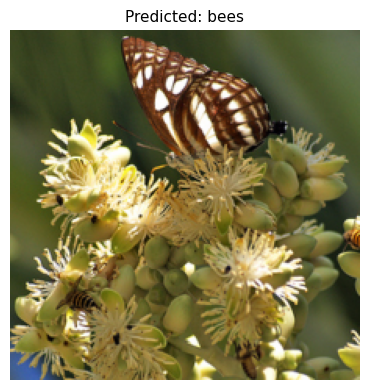

In [18]:
visualize_predictions(
    ffe_model,
    img_paths=["/content/drive/MyDrive/data/hymenoptera_data/val/bees/72100438_73de9f17af.jpg"]
)
